# 3.1 Layer-wise Relevance Propagation

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_3_1 import MNIST_NN, MNIST_DNN, LRP

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/3_1_LRP/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular DNN classifier is initialized and necessary nodes for model training is added onto the graph. In this particular tutorial, I used a fully connected neural network with ReLU activations and without bias in order to satisfy the $f(tx) = tf(x)$ property mentioned in the introduction.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_DNN('DNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    activations, logits = DNN(X)
    
    tf.add_to_collection('LRP', X)
    
    for activation in activations:
        tf.add_to_collection('LRP', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the DNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

sess.close()

Epoch: 0001 cost = 0.217467772 accuracy = 0.933436365
Epoch: 0002 cost = 0.098115265 accuracy = 0.970236372
Epoch: 0003 cost = 0.066195414 accuracy = 0.979527283
Epoch: 0004 cost = 0.048386373 accuracy = 0.984890920
Epoch: 0005 cost = 0.042582519 accuracy = 0.986763647
Epoch: 0006 cost = 0.033483940 accuracy = 0.989181827
Epoch: 0007 cost = 0.026339417 accuracy = 0.991927280
Epoch: 0008 cost = 0.025810467 accuracy = 0.992527279
Epoch: 0009 cost = 0.025183206 accuracy = 0.992345462
Epoch: 0010 cost = 0.025339973 accuracy = 0.992636370
Epoch: 0011 cost = 0.015878835 accuracy = 0.994872732
Epoch: 0012 cost = 0.020530643 accuracy = 0.993709097
Epoch: 0013 cost = 0.017444806 accuracy = 0.994963641
Epoch: 0014 cost = 0.012844828 accuracy = 0.996381822
Epoch: 0015 cost = 0.014824310 accuracy = 0.995818186
Accuracy: 0.9804


### 4. Restoring Subgraph

Here we first rebuild the DNN graph from metagraph, restore DNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function.

In [21]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')
biases = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*bias.*')

activations = tf.get_collection('LRP')
X = activations[0]

INFO:tensorflow:Restoring parameters from ./tf_logs/3_1_LRP/model


### 5. Attaching Subgraph for Calculating Relevance Scores

In [22]:
conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

lrp = LRP(1, activations, weights, biases, conv_ksize, pool_ksize, conv_strides, pool_strides, 'LRP')

Rs = []
for i in range(10):
    Rs.append(lrp(i))

### 6. Calculating Relevance Scores $R(x_i)$

In [24]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

imgs = []
for i in range(10):
    imgs.append(sess.run(Rs[i], feed_dict={X: sample_imgs[i][None,:]}))

sess.close()

### 7. Displaying Images

The gradients are visualized as heat maps. You can see which features/data points influenced the DNN most its decision making.

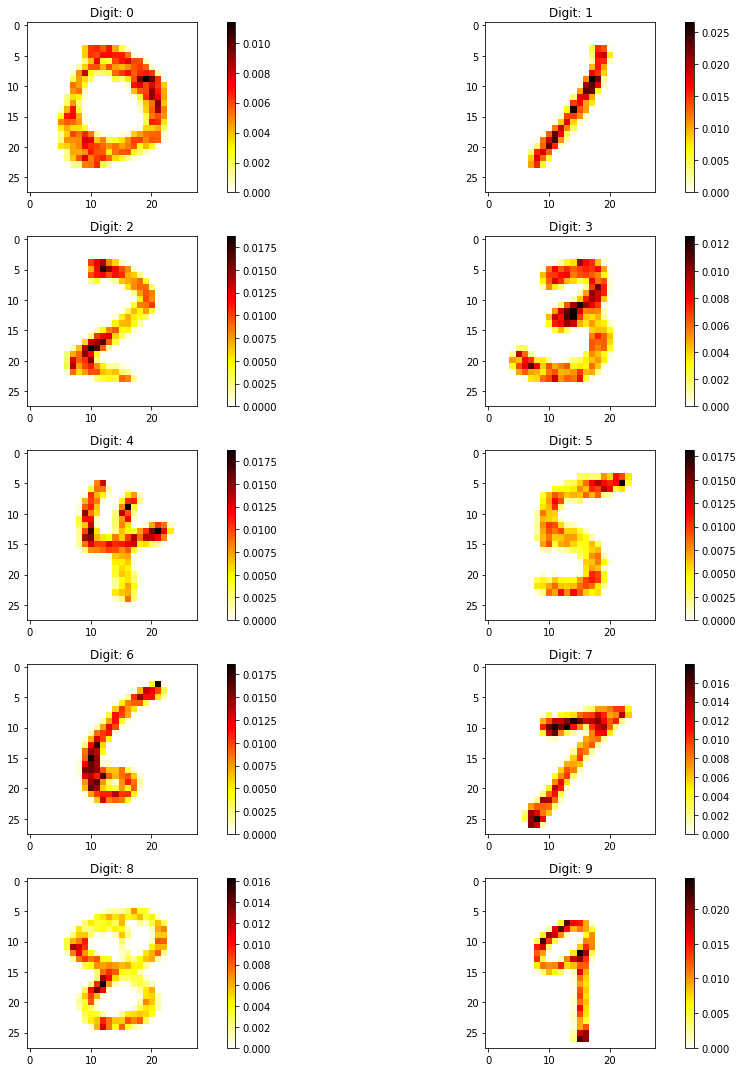

In [25]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(imgs[2 * i], [28, 28]), cmap='hot_r')
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(imgs[2 * i + 1], [28, 28]), cmap='hot_r')
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()

### The LRP Process in Numpy

In [ ]:
def pos_neg(x):
    return np.maximum(x, 0), np.minimum(x, 0)

z_23 = np.transpose(Xs[2]) * Ws[2][:,logit,None]  # [128,1] = [128,1] * [128,1]

z_23_p, z_23_n = pos_neg(z_23)
b_3_p, b_3_n = pos_neg(bs[2][logit,None])

z_3_p = np.sum(z_23_p, axis=0) + b_3_p
z_3_n = np.sum(z_23_n, axis=0) + b_3_n

R_32 = Xs[-1][:,logit] * (alpha * z_23_p / z_3_p + beta * z_23_n / z_3_n) # [128,1] = [1] * [128,1]
R2 = np.sum(R_32, axis=1) # [128,1] --> [128]

z_12 = np.transpose(Xs[1]) * Ws[1]     # [512,128] = [512,1] * [512,128]

z_12_p, z_12_n = pos_neg(z_12)
b_2_p, b_2_n = pos_neg(bs[1])

z_2_p = np.sum(z_12_p, axis=0) + b_2_p
z_2_n = np.sum(z_12_n, axis=0) + b_2_n

R_21 = R2 * (alpha * z_12_p / z_2_p + beta * z_12_n / z_2_n) # [512,128] = [128] * [512,128] / [128]
R1 = np.sum(R_21, axis=1) # [512,128] --> [512]

z_01 = np.transpose(Xs[0]) * Ws[0]     # [784,512] = [784,1] * [784,512]

z_01_p, z_01_n = pos_neg(z_01)
b_1_p, b_1_n = pos_neg(bs[0])

z_1_p = np.sum(z_01_p, axis=0) + b_1_p
z_1_n = np.sum(z_01_n, axis=0) + b_1_n

R_10 = R1 * (alpha * z_01_p / (z_1_p + eps) + beta * z_01_n / (z_1_n - eps)) # [784,512] = [512] * [784,512] / [512]
R0 = np.sum(R_10, axis=1) # [784,512] --> [784]